In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pytz
from pandas.io.sql import read_sql
from pyiem.util import get_dbconn

In [15]:
IEM = get_dbconn('iem')

df = read_sql("""SELECT valid, drct, id as station,
 wcht(tmpf::numeric, (sknt*1.15)::numeric), tmpf, greatest(sknt,gust),
 case when 'CLR' in (skyc1, skyc2, skyc3, skyc4) then 0 else 1 end as ovc,
 id from current_log c JOIN stations t ON (t.iemid = c.iemid)
 WHERE t.network in ('IA_ASOS', 'AWOS')
 and tmpf is not null 
 ORDER by valid ASC
 """, IEM, index_col=None)

In [40]:
x = []
y = []
base = datetime.datetime(2017, 1, 11, 6).replace(tzinfo=pytz.utc)
for hr in range(24):
    sts = base + datetime.timedelta(hours=hr)
    ets = sts + datetime.timedelta(hours=1)
    x.append(sts)
    df2 = df[(df['valid'] >= sts) & (df['valid'] < ets)]
    df2 = df2.sort_values('tmpf')
    y.append(df2['tmpf'].max() - df2['tmpf'].min())
    print hr, df2[['id', 'tmpf', 'valid']].head(1), df2[['id', 'tmpf', 'valid']].tail(1), y[-1]


0        id  tmpf                     valid
1428  RUG  -9.4 2017-01-11 06:55:00+00:00        id  tmpf                     valid
1147  BWG  54.0 2017-01-11 06:53:00+00:00 63.4
1        id  tmpf                     valid
3215  RUG -11.2 2017-01-11 07:55:00+00:00        id  tmpf                     valid
2187  BWG  53.1 2017-01-11 07:25:00+00:00 64.3
2        id  tmpf                     valid
5068  MIB -13.4 2017-01-11 08:58:00+00:00        id  tmpf                     valid
3418  BWG  53.1 2017-01-11 08:04:00+00:00 66.5
3        id  tmpf                     valid
6667  RUG -16.6 2017-01-11 09:55:00+00:00        id  tmpf                     valid
6533  TKX  53.6 2017-01-11 09:55:00+00:00 70.2
4        id  tmpf                     valid
8280  RUG -18.4 2017-01-11 10:55:00+00:00        id  tmpf                     valid
7602  TKX  55.4 2017-01-11 10:35:00+00:00 73.8
5        id  tmpf                     valid
8723  RUG -20.2 2017-01-11 11:15:00+00:00        id  tmpf                     val

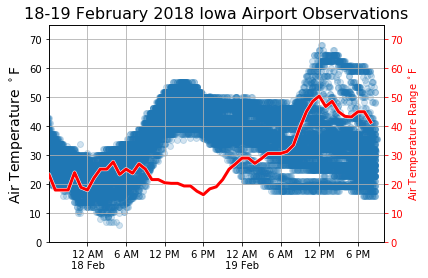

In [31]:
sts = datetime.datetime(2018, 2, 18, 0)
ets = datetime.datetime(2018, 2, 20, 4)
interval = datetime.timedelta(hours=1)
xticks = []
xticklabels = []
now = sts
while now < ets:
    if now.hour % 6 != 0:
        now += interval
        continue
    fmt = "%-I %p" if now.hour != 0 else '%-I %p\n%d %b'
    xticks.append(now + datetime.timedelta(hours=6))
    xticklabels.append(now.strftime(fmt))
    now += interval

(fig, axes) = plt.subplots(1 ,1)#, figsize=(8,7), sharex=True)
ax = axes
#df2 = df[df['ovc'] == 1]
#ax.scatter(df2['valid'].values, df2['tmpf'].values, marker='x', color='grey', alpha=0.2,
#          label='Cloudy')
#df2 = df[df['ovc'] == 0]
ax.scatter(df['valid'].values, df['tmpf'].values, marker='o', alpha=0.2)
ax.set_title(("18-19 February 2018 Iowa Airport Observations"),
            fontsize=16)
ax.set_ylabel("Air Temperature $^\circ$F", fontsize=14)
#ax.set_yticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
#ax.set_yticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'], fontsize=14)
#ax.set_ylim(-1, 361)
#leg = ax.legend()
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
ax.grid(True)
ax.set_ylim(0, 75)

x = []
y = []
for dt, gdf in df.groupby(df['valid'].dt.strftime("%Y%m%d%H")):
    rng = gdf['tmpf'].max() - gdf['tmpf'].min()
    if rng < 10:
        continue
    x.append(datetime.datetime.strptime(dt, '%Y%m%d%H'))
    y.append(rng)

ax2 = ax.twinx()
ax2.plot(x, y, color='white', zorder=5, lw=4)
ax2.plot(x, y, color='r', zorder=5, lw=3)
ax2.set_xticks([])
ax2.set_ylim(0, 75)
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel("Air Temperature Range $^\circ$F", color='r')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(sts, ets)


#ax = axes[1]
#ax.plot(x, y)
#ax.grid(True)
#ax.set_ylabel("Temperature Spread $^\circ$F")
fig.savefig('180220.png', dpi=200)